In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch,torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torch.optim as optim

In [2]:
print(torch.__version__)
! python --version

0.3.1.post3
Python 3.6.4 :: Anaconda, Inc.


In [3]:
#  CUDA
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else '"cpu')
torch.cuda.set_device(0)
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [4]:
# Copied to make it work. Was giving errors
try:
    torch._utils._rebuild_tensor_v2
except AttributeError:
    def _rebuild_tensor_v2(storage, storage_offset, size, stride, requires_grad, backward_hooks):
        tensor = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)
        tensor.requires_grad = requires_grad
        tensor._backward_hooks = backward_hooks
        return tensor
    torch._utils._rebuild_tensor_v2 = _rebuild_tensor_v2

In [5]:
# Hyperparameters 
num_epochs = 20
batchSize = 4

In [6]:
# Transformation Function
transform_to = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [7]:
# Loading the data
trainData = torchvision.datasets.CIFAR10(root = './CIFAR10', transform = transform_to,download = True)
trainLoader = torch.utils.data.DataLoader(trainData,batch_size=batchSize,shuffle = True)

testData = torchvision.datasets.CIFAR10(root = './data/', transform = transform_to,train = False, download = True)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
classes = ['plane', 'car', 'bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
def plot_images(images,labels = None):
    figure = plt.figure(figsize=(10,10))
    for i in range(len(images)):
        unnormalized_image = images[i]*0.5 + 0.5
        ax = plt.subplot(1,len(images),i+1)
        plt.imshow(unnormalized_image)
        plt.axis('off')
        if labels is not None:
            plt.title(classes[labels[i]])
            

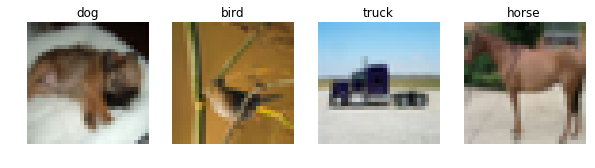

In [10]:
sample = next(iter(trainLoader))
image, label = sample
plot_images(np.transpose(image.numpy(),(0,2,3,1)), label.numpy())

In [11]:
image.shape, label.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [12]:
class My_Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    
    def forward(self,x):
        # Input image size -> 32x32x3
        x = self.max_pool(F.relu(self.conv1(x))) # 14x14x6
        x = self.max_pool(F.relu(self.conv2(x))) #5x5x16
        x = x.view(-1,5*5*16) 
        x = F.relu(self.fc1(x)) #120
        x = F.relu(self.fc2(x)) #84
        x = self.fc3(x) #10
        return x
        

In [13]:
def train(network,optimizer,loss_func, Loader,num_epoch):
    loss_list = []
    for epoch in range(num_epoch):
        epoch_loss = []
        for data in Loader:
            images, labels = data
            images, labels = Variable(images).cuda(), Variable(labels).cuda()
            optimizer.zero_grad()
            outputs = network(images)
            loss = loss_func(outputs, labels)
            epoch_loss.append(loss.data[0])
            loss.backward()
            optimizer.step()
        mean_epoch_loss = np.array(epoch_loss).mean()
        loss_list.append(mean_epoch_loss)
        print(f'Epoch: {epoch+1}, Loss: {mean_epoch_loss:.3f}')
    print('Finished Training!')
    return loss_list
            
    
def predict(network,Loader):
    correct = 0
    total = 0
    for data in Loader:
        images, labels = data
        images = Variable(images).cuda()
        outputs = network(images)
        class_score,preds = torch.max(outputs.data,1)
        total += len(labels)
        correct += (preds == labels.cuda()).sum()
    
    print(f'Accuracy on the Test Set: {correct*100/total}%')
    
def plot_train_loss(losses,title):
    plt.plot(losses)
    plt.title(title)
    plt.xlabel('No. of Epochs')
    plt.ylabel('Training Loss')

In [14]:
model = My_Network().cuda()

In [15]:
model.eval()

My_Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
loss_criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr = 0.001, momentum=0.9)

In [17]:
train_loss = train(model,opt,loss_criterion,trainLoader,30)

Epoch: 1, Loss: 1.731
Epoch: 2, Loss: 1.323
Epoch: 3, Loss: 1.185
Epoch: 4, Loss: 1.102
Epoch: 5, Loss: 1.036
Epoch: 6, Loss: 0.985
Epoch: 7, Loss: 0.945
Epoch: 8, Loss: 0.910
Epoch: 9, Loss: 0.872
Epoch: 10, Loss: 0.850
Epoch: 11, Loss: 0.825
Epoch: 12, Loss: 0.802
Epoch: 13, Loss: 0.779
Epoch: 14, Loss: 0.761
Epoch: 15, Loss: 0.748
Epoch: 16, Loss: 0.731
Epoch: 17, Loss: 0.725
Epoch: 18, Loss: 0.712
Epoch: 19, Loss: 0.695
Epoch: 20, Loss: 0.690
Epoch: 21, Loss: 0.676
Epoch: 22, Loss: 0.674
Epoch: 23, Loss: 0.669
Epoch: 24, Loss: 0.661
Epoch: 25, Loss: 0.660
Epoch: 26, Loss: 0.651
Epoch: 27, Loss: 0.648
Epoch: 28, Loss: 0.655
Epoch: 29, Loss: 0.632
Epoch: 30, Loss: 0.631
Finished Training!


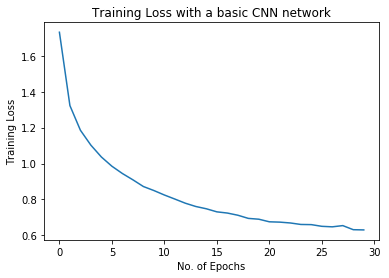

In [18]:
plot_train_loss(train_loss, 'Training Loss with a basic CNN network')

In [19]:
predict(model,testLoader)

Accuracy on the Test Set: 59.51%


This is the baseline for the experimentation. Accuracy of network on CIFAR10 test set is about 62.03%

<b> Running Batch-Norm

In [20]:
class BN_Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc1_bn = nn.BatchNorm2d(120)
        self.fc2 = nn.Linear(120,84)
        self.fc2_bn = nn.BatchNorm2d(84)
        self.fc3 = nn.Linear(84,10)
    
    
    def forward(self,x):
        # Input image size -> 32x32x3
        x = self.max_pool(self.conv1_bn(F.relu(self.conv1(x)))) # 14x14x6
        x = self.max_pool(self.conv2_bn(F.relu(self.conv2(x)))) #5x5x16
        x = x.view(-1,5*5*16) 
        x = self.fc1_bn(F.relu(self.fc1(x))) #120
        x = self.fc2_bn(F.relu(self.fc2(x))) #84
        x = self.fc3(x) #10
        return x

In [21]:
model_bn = BN_Network().cuda()

In [22]:
model_bn.eval

<bound method Module.eval of BN_Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc1_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_bn): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

In [23]:
loss_criterion2 = nn.CrossEntropyLoss()
opt2 = optim.SGD(model_bn.parameters(),lr = 0.001, momentum=0.9)

In [24]:
train_loss_bn = train(model_bn,opt2,loss_criterion2,trainLoader,30)

Epoch: 1, Loss: 1.945
Epoch: 2, Loss: 1.749
Epoch: 3, Loss: 1.648
Epoch: 4, Loss: 1.590
Epoch: 5, Loss: 1.552
Epoch: 6, Loss: 1.523
Epoch: 7, Loss: 1.503
Epoch: 8, Loss: 1.478
Epoch: 9, Loss: 1.451
Epoch: 10, Loss: 1.442
Epoch: 11, Loss: 1.438
Epoch: 12, Loss: 1.410
Epoch: 13, Loss: 1.408
Epoch: 14, Loss: 1.419
Epoch: 15, Loss: 1.394
Epoch: 16, Loss: 1.402
Epoch: 17, Loss: 1.432
Epoch: 18, Loss: 1.388
Epoch: 19, Loss: 1.357
Epoch: 20, Loss: 1.379
Epoch: 21, Loss: 1.382
Epoch: 22, Loss: 1.371
Epoch: 23, Loss: 1.346
Epoch: 24, Loss: 1.354
Epoch: 25, Loss: 1.332
Epoch: 26, Loss: 1.330
Epoch: 27, Loss: 1.322
Epoch: 28, Loss: 1.322
Epoch: 29, Loss: 1.320
Epoch: 30, Loss: 1.319
Finished Training!


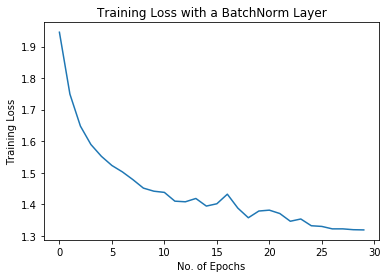

In [25]:
plot_train_loss(train_loss_bn, 'Training Loss with a BatchNorm Layer')

In [26]:
predict(model_bn,testLoader)

Accuracy on the Test Set: 52.74%
